<a href="https://colab.research.google.com/github/keinerfan/CIAP_ANN/blob/main/morgan_fingerprint_tweaking_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

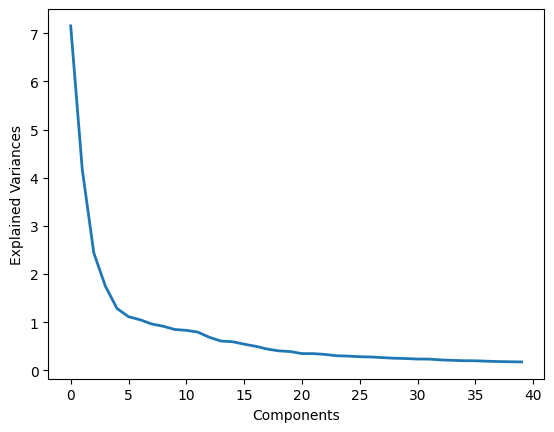

In [7]:
# -*- coding: utf-8 -*-
"""multi_layer_perceptron_for_BICR.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1u2-xk0FuW_rHBLNHdmKI9TqmS-T7Itfq
"""
from matplotlib.pyplot import plot, xlabel, ylabel, show
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  # Importing plt for show() function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the dataset
data = pd.read_csv("CIAP1_and_CIAP2_06_morgan_fp.csv")

y = data.pIC50.values.reshape((-1,1))
data = data.drop(['pIC50'] , axis = 1 )
# Feature selection using VarianceThreshold
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca.fit(data)
merged_data = pca.transform(data)
plot(pca.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variances')  # Corrected spelling
plt.show()  # Corrected function call

# Prepare X and y


x = merged_data
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize y using StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert data to PyTorch tensors
device = torch.device("cpu")
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


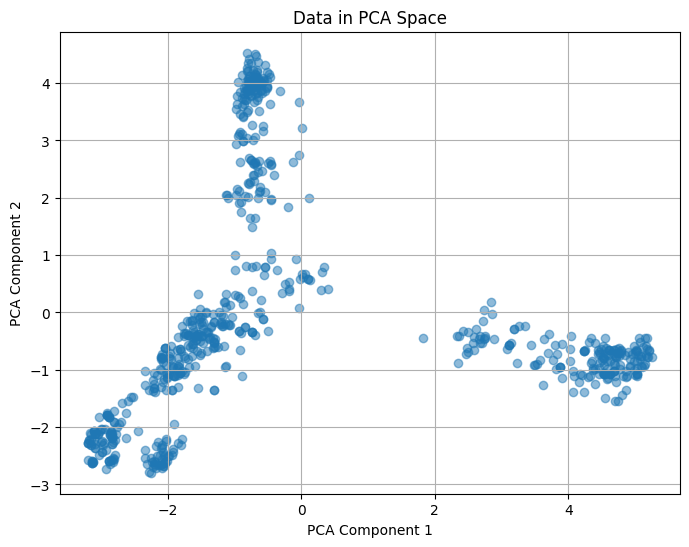

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(8, 6))
plt.scatter(merged_data[:, 0], merged_data[:, 1], alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data in PCA Space')
plt.grid(True)
plt.show()

# **this part is for fun and checking  model without inactive compounds**

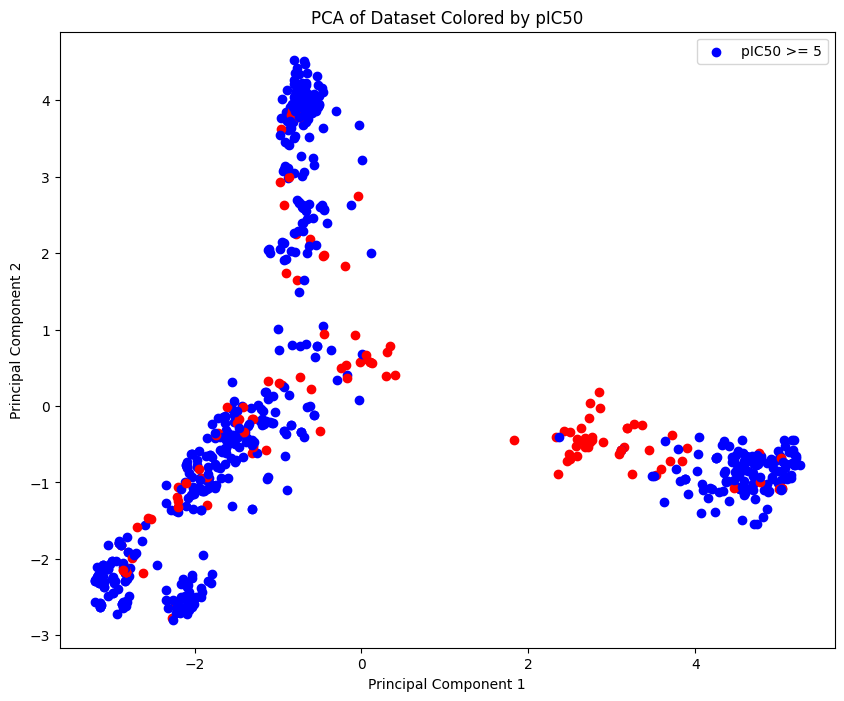

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
for i in range(len(y)):
    if y[i] < 5:
        plt.scatter(merged_data[i, 0], merged_data[i, 1], color='red', label='pIC50 < 5' if i == 0 else "")
    else:
        plt.scatter(merged_data[i, 0], merged_data[i, 1], color='blue', label='pIC50 >= 5' if i == 0 else "")

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset Colored by pIC50')
plt.legend(loc='best')

# Show plot
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming merged_x is your feature matrix and y is your target variable array

# Ensure y is a 1D array
y = np.squeeze(np.asarray(y))

# Filter data where y (pIC50) is greater than or equal to 5
active_mask = y >= 5
merged_data_active = merged_data[active_mask]
y_active = y[active_mask]

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(merged_data_active, y_active, test_size=0.2, random_state=42)


# Initialize and train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)

# Predict on the test set
y_pred = svr.predict(X_test)

# Calculate and print metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 0.2930
Mean Absolute Error (MAE): 0.3640
R-squared (R2): 0.7801


# **relu and adam**

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        #self.ln4 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        #adding new layer to check
        #out = self.fc4(out)
        #out = self.ln4(out)
        #out = self.activation(out)
        #out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 40
hidden_size = 512
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [ ]:

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:   0 Training loss: 20.71
Epoch:  10 Training loss: 2.53
Epoch:  20 Training loss: 2.47
Epoch:  30 Training loss: 2.26
Epoch:  40 Training loss: 2.23
Epoch:  50 Training loss: 2.21
Epoch:  60 Training loss: 2.28
Epoch:  70 Training loss: 2.20
Epoch:  80 Training loss: 2.19
Epoch:  90 Training loss: 2.04
Epoch: 100 Training loss: 2.20
Epoch: 110 Training loss: 2.26
Epoch: 120 Training loss: 2.13
Epoch: 130 Training loss: 2.08
Epoch: 140 Training loss: 2.08
Epoch: 150 Training loss: 2.15
Epoch: 160 Training loss: 2.02


KeyboardInterrupt: 

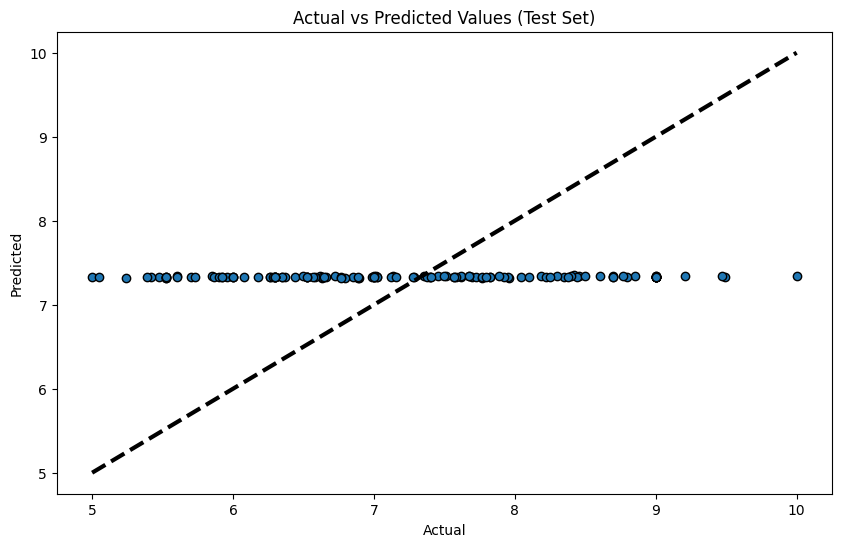

Training Set Metrics:
R-Squared: 0.005649611800192189
Adjusted R-Squared: -0.0747019347210045
Mean Squared Error (MSE): 1.320159673690796
Mean Absolute Error (MAE): 0.9802428483963013
Mean Absolute Percentage Error (MAPE): 14.037646353244781

Testing Set Metrics:
R-Squared: -0.0026585699581247457
Adjusted R-Squared: -0.4339095677895761
Mean Squared Error (MSE): 1.3356280326843262
Mean Absolute Error (MAE): 0.9805284142494202
Mean Absolute Percentage Error (MAPE): 14.168046414852142


In [ ]:

#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = model(X_train)
y_test_pred = model(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')

# **bayesian opt and sigmoid activation**

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(512, out_size)
        self.ln1 = nn.LayerNorm(512)
        self.ln2 = nn.LayerNorm(512)
        self.ln3 = nn.LayerNorm(512)
        #self.ln4 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)


        #adding new layer to check
        #out = self.fc4(out)
        #out = self.ln4(out)
        #out = self.activation(out)
        #out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 40
hidden_size = 512
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [9]:
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)

Epoch:   0 Training loss: 1.82
Epoch:  10 Training loss: 0.66
Epoch:  20 Training loss: 0.39
Epoch:  30 Training loss: 0.40
Epoch:  40 Training loss: 0.36
Epoch:  50 Training loss: 0.30
Epoch:  60 Training loss: 0.27
Epoch:  70 Training loss: 0.27
Epoch:  80 Training loss: 0.26
Epoch:  90 Training loss: 0.24
Epoch: 100 Training loss: 0.23
Epoch: 110 Training loss: 0.23
Epoch: 120 Training loss: 0.22
Epoch: 130 Training loss: 0.21
Epoch: 140 Training loss: 0.20
Epoch: 150 Training loss: 0.20
Epoch: 160 Training loss: 0.20
Epoch: 170 Training loss: 0.19
Epoch: 180 Training loss: 0.19
Epoch: 190 Training loss: 0.16


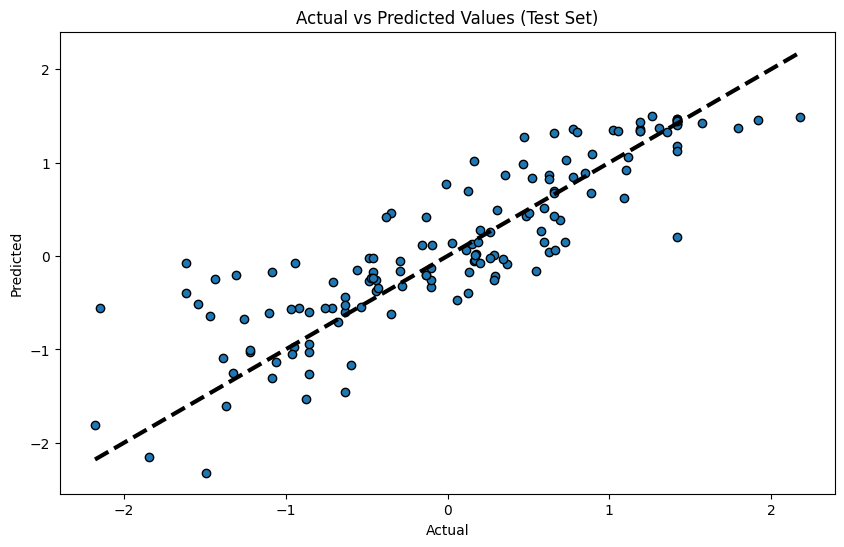

Training Set Metrics:
R-Squared: 0.8947415577615191
Adjusted R-Squared: 0.8867218669243015
Mean Squared Error (MSE): 0.10525844246149063
Mean Absolute Error (MAE): 0.23363764584064484
Mean Absolute Percentage Error (MAPE): 80.41309714317322

Testing Set Metrics:
R-Squared: 0.7535215651253939
Adjusted R-Squared: 0.6559063433928767
Mean Squared Error (MSE): 0.2151643931865692
Mean Absolute Error (MAE): 0.34056973457336426
Mean Absolute Percentage Error (MAPE): 132.78568983078003


In [10]:

#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = model(X_train)
y_test_pred = model(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')

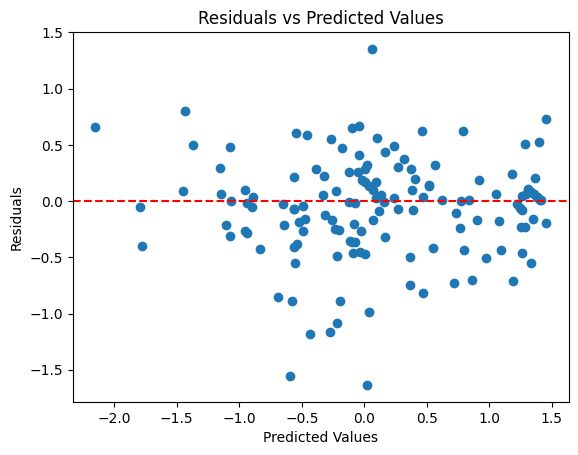

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'actual' and 'predicted' are your actual and predicted values

residuals = y_test - y_pred_test.detach().numpy()

plt.scatter(y_pred_test.detach().numpy(), residuals)
plt.xlabel('Predicted Values')

plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
